# **Data Cleaning Notebook**

## Objectives

*   Evaluate missing data
*   Clean data

## Inputs

* outputs/datasets/collection/airplane_performance_study.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Conclusions

 
  * Data Cleaning Pipeline
  * Drop Variables:  `['Model', 'Company', 'THR', 'SHP']`



---


# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Load Collected data

In [4]:
import pandas as pd
df_raw_path = "/workspace/data-driven-design/outputs/datasets/collection/airplane_performance_study.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,Model,Company,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,THR,SHP,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,15 AC Sedan,Aeronca,37.416667,25.250000,10.250000,False,False,0,NaN,145.0,...,46.0,370.0,13000.0,13000.0,450.0,450.0,900.0,391.970247,1300.0,257.745075
1,11 CC Super Chief,Aeronca,36.083333,20.583333,8.750000,False,False,0,NaN,85.0,...,44.0,190.0,12300.0,12300.0,600.0,600.0,720.0,26.247647,800.0,225.324824
2,7 CCM Champ,Aeronca,35.000000,21.416667,8.583333,False,False,0,NaN,90.0,...,37.0,210.0,16000.0,16000.0,650.0,650.0,475.0,363.139711,850.0,585.751317


# Data Cleaning - Part 1

## Assessing Missing Data Levels

This dataset is already cleaned thus we should be able to expect no missing data however `['THR', 'SHP']` do have apparent missing data in its columns. The reason for this is that "size" of an engine is measured with different quantities/units depending on ` Engine Type`. The jet is measured in quantity of force (unit: THR) and the piston and propjet (both propeller) is measured using power (unit: SHP). For this reason these units are split into two separate columns and a jet data point will then have N/A in the SHP column and a prop or propjet (turbo prop) will have a N/A in the THR column. 

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['THR', 'SHP']

In [6]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
THR,703,82.03,float64
SHP,154,17.97,float64


## Features to drop

We will drop the following features:
* `'THR'` and `'THR'` since these are different quantities with different untis and therefore difficult to compare with each other.
* `'Model'` and `'Company'` since this meta data only serve as identifier variables


### Drop Variables

We drop values in this stage already since subsequents code otherwise would fail. 

List here the data cleaning approaches you want initially to try.
* Drop - `['Model', 'Company', 'THR', 'SHP']`

In [7]:
# Columns to drop
columns_to_drop = ['Model', 'Company', 'THR', 'SHP']

# Dropping the columns
df_dropped = df.drop(columns=columns_to_drop)

# Overwriting to the droped data frame
df =  df_dropped
# Display the modified DataFrame
#print(df)
df.head(3)

,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,False,False,0,2050.0,1180.0,241.2,104.0,...,46.0,370.0,13000.0,13000.0,450.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,False,False,0,1350.0,820.0,100.5,89.0,...,44.0,190.0,12300.0,12300.0,600.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,False,False,0,1300.0,810.0,127.3,90.0,...,37.0,210.0,16000.0,16000.0,650.0,650.0,475.0,363.139711,850.0,585.751317


WARNING!!!!!!!!!!!!! I have written the original data frame here above (df =  df_dropped)! Is this ok!?

# Data Exploration

Deletebelow cell, I do not think it is needed!

In [8]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")


KeyError: "None of [Index(['THR', 'SHP'], dtype='object')] are in the [columns]"

# Correlation and PPS Analysis

In [9]:
pip install ppscore

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


Calculate Correlations and Power Predictive Score

In below cell I have to drop values to make the correlation below to work. Why do I have to drop these values when the Churnometer did not have to drop any columns to work!?

In [11]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_dropped)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min    25%    50%    75%    max
ppscore  420.0  0.385  0.246  0.0  0.185  0.421  0.558  0.896


Display at Heatmaps

Probably delete below 'uppgrade cell' it is not needed but check before removing!

In [12]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [14]:
df = pd.DataFrame(df_dropped)
print(df.dtypes)

# column_dtype = df_dropped.dtype
# print(column_dtype)


Wing_Span       float64
Length          float64
Height          float64
Multi_Engine       bool
TP_mods            bool
Engine_Type       int64
AUW             float64
MEW             float64
FW              float64
Vmax            float64
Vcruise         float64
Vstall          float64
Range           float64
Hmax            float64
Hmax_(One)      float64
ROC             float64
ROC_(One)       float64
Vlo             float64
Slo             float64
Vl              float64
Sl              float64
dtype: object


Solve issue with "AttributeError: model 'numpy' has no attribute 'bool'. 'np.bool' was a deprecated alias for the builtin 'bool'..."

In [15]:
import numpy as np
np.bool = np.bool_

Solve issue that the plots were not being displayed

In [16]:
%matplotlib inline

We have added the Predictive Power Score (PPS) since PPS also can detect non-linear relationships that the traditional metrics like Pearson or Spearman correlations might miss.

Observations and conclusion from below heatmaps:

* We naturally see high correlation between features of the same kind, e.g. we see high correlation (0,85 - 0,88) between the "weight"-features like "All Up Weight" (AUW), Fuel Weight(FW) and "Manufacturer Empty Weight" (MEW) since both are "weight"-features. We also see high correlation between features in related kinds, e.g. the size of the airplane (Height, Length and Wing Span) are obvioously strongly related to airplanes weight (AUW, FW and MEW).

Albeit not really interresting from an Airplane Design perspective these relationships can still be used to predict values in a meaningfull way. Note also that it due to structural and aerodynamic Scale factors the relatinship between size and weight might not be linear. 

* Interesting correlation between: 0.8 - 1.0:



Now we run the correlation again with elevated thressholds as to only filter out the weakly correlation values leaving only **moderate** to **strongly** correlated features



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



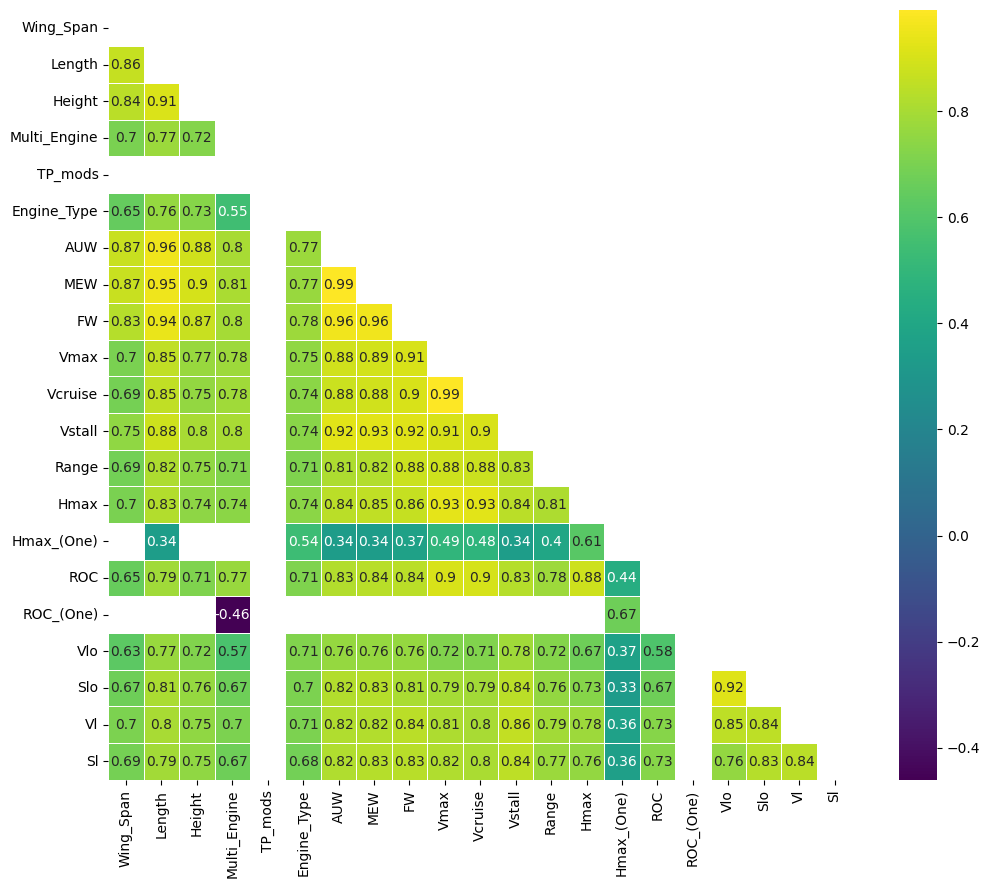



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



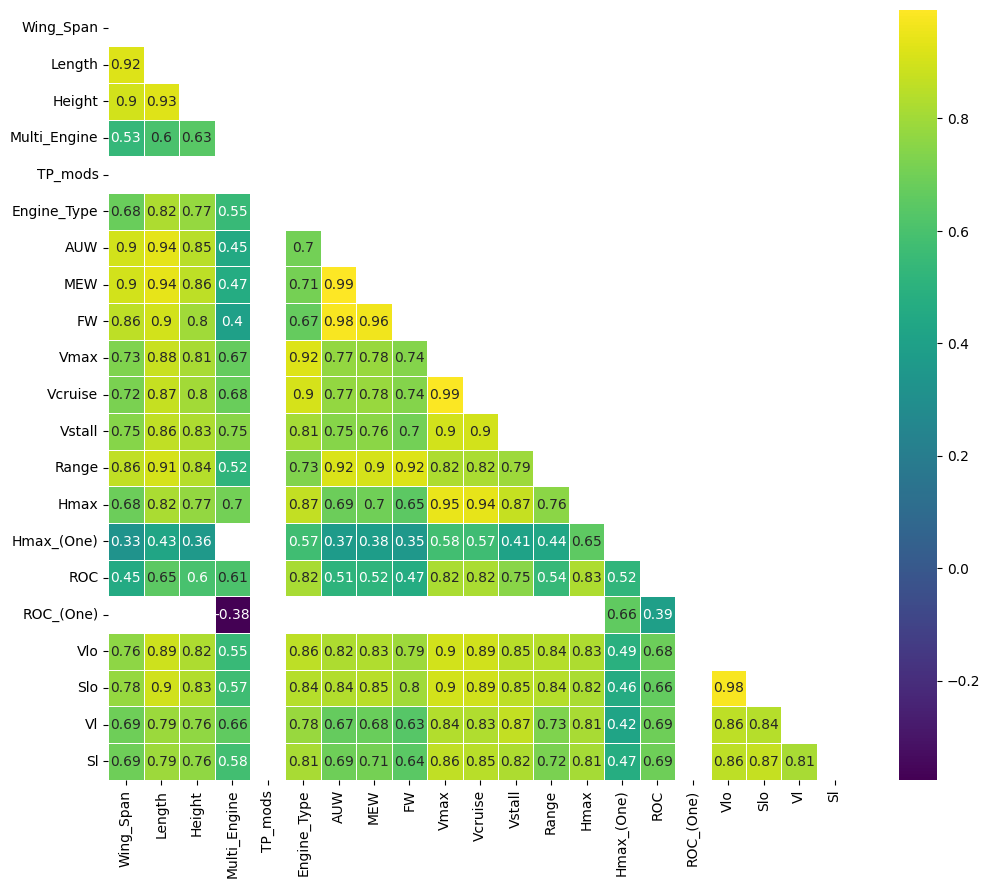



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



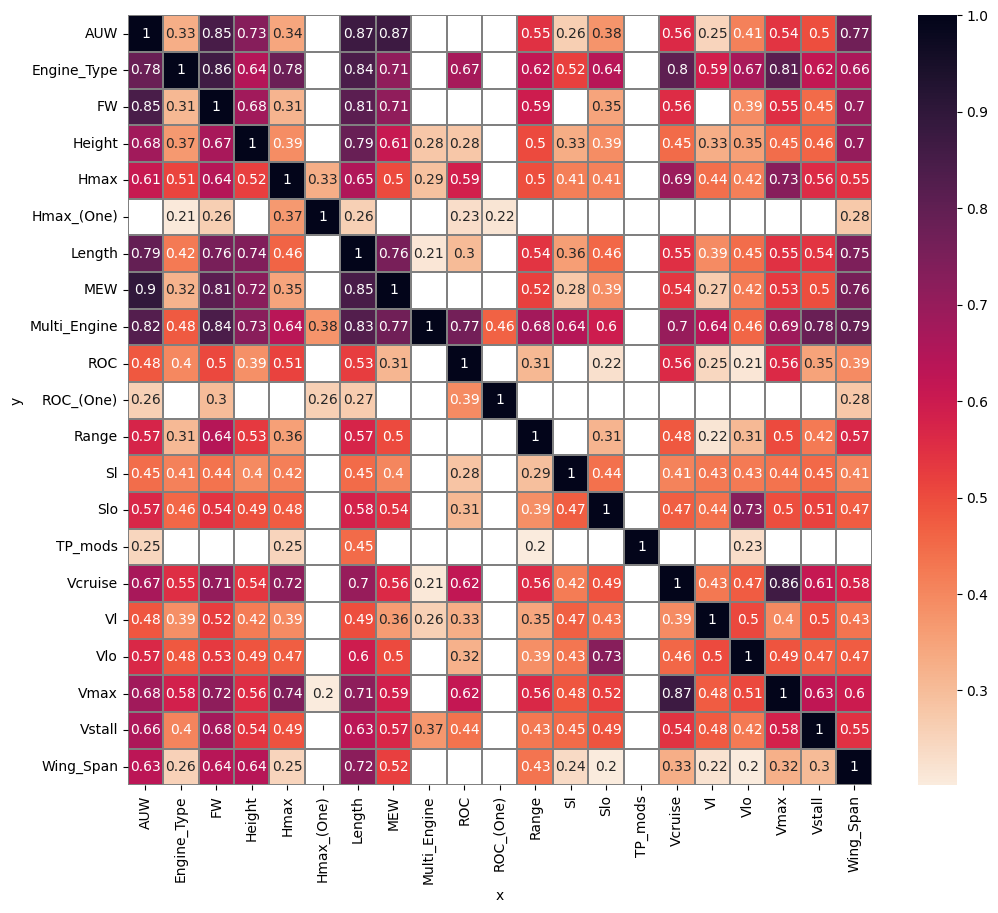

In [17]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.3, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

Now we run the correlation again with elevated thresholds as to only filter out both weakly and moderate correlation values leaving only **strongly** correlated features



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



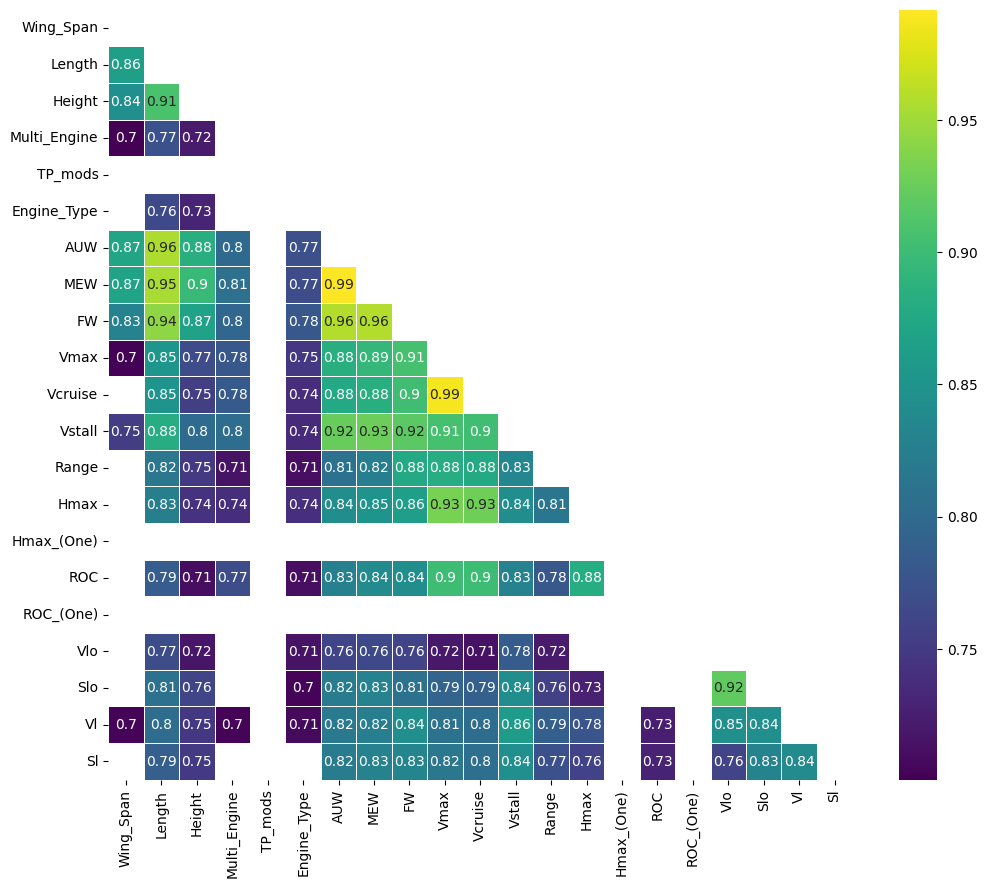



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



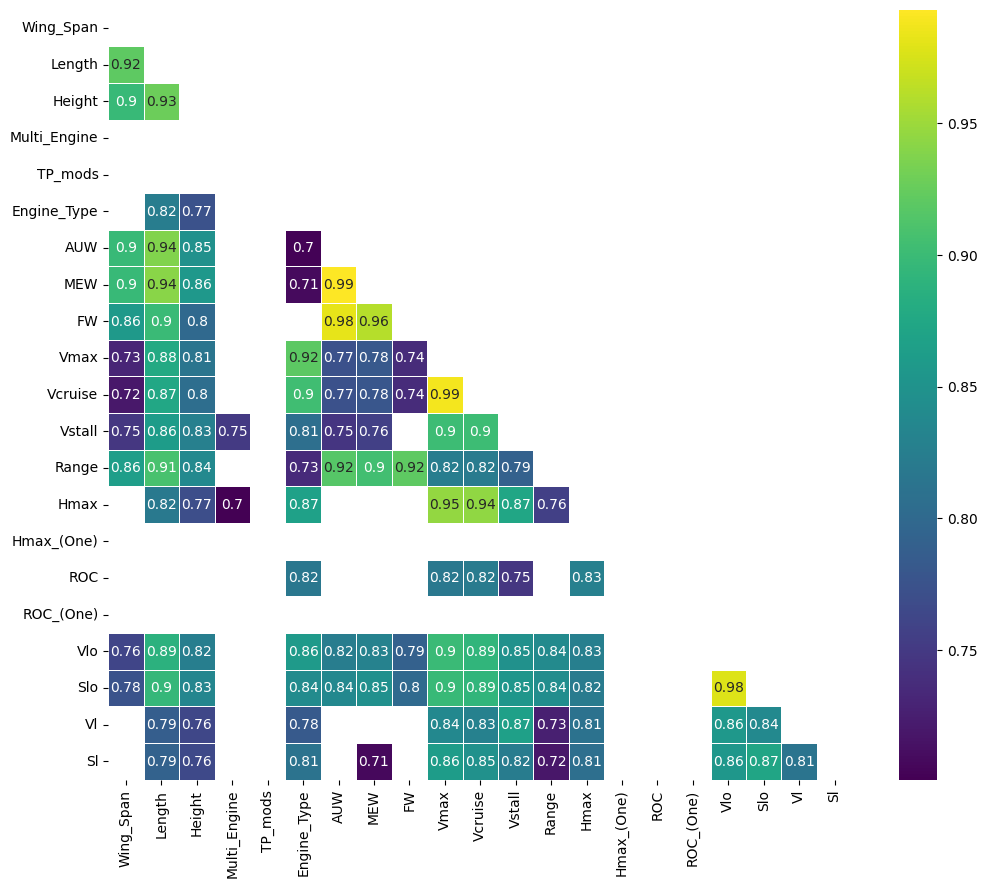



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



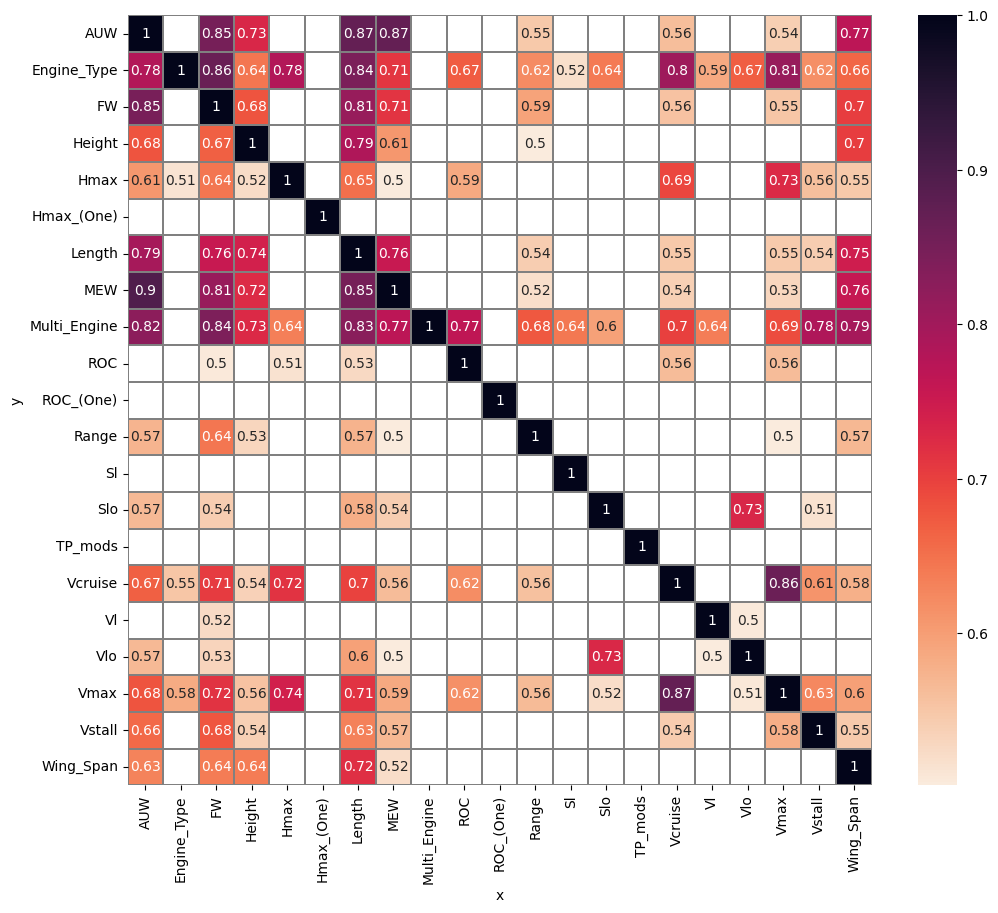

In [18]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.7, PPS_Threshold =0.5,
                  figsize=(12,10), font_annot=10)

# Data Cleaning - Part 2

XXXXXXXXXXXXXXXXXXXXXXXX Should I remove outliers or not here!?
Strategies for Handling Outliers
Investigation: Before deciding to remove or retain outliers, investigate their cause. Are they valid observations, or are they due to errors?
Robust Models: Some models (like decision trees or robust regression techniques) are less sensitive to outliers and can handle them effectively.
Transformation: In some cases, applying transformations (like log or square root) can reduce the impact of outliers.
In summary, while outliers can represent real data, their influence on analysis and models can be problematic. It's important to assess each case individually and consider their potential effects on your specific goals.

Also it depends on if we want to model conventional airplanes or extreme airplanes that has singled out one or a few feature, e.g. speed, to be adressed with a really agressive design!

## Assessing Missing Data Levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

## Data Cleaning Spreadsheet Summary

This dataset doesn't require much data cleaning, therefore we are not loading the DataCleaningEffect() function we studied in the feature-engine lesson.
* For your future projects, this would be a moment to load that function and use it over your data-cleaning process.
* For this project, we are skipping this part.

### Data Cleaning Summary

The following data cleaning actions have been taken:
* Drop - `['Model', 'Company', 'THR', 'SHP']`

### Split Train and Test Set

In [19]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['Multi_Engine'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (685, 21) 
TestSet shape: (172, 21)


In [20]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


# Push cleaned data to Repo

In [21]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/cleaned'


## Train Set

In [22]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test Set

In [23]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)